In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from PIL import Image
import os

import mtcnn

image_path = "../../faces/"
image_files = [f for f in os.listdir(image_path) if f[-5:] != '2.jpg']

## Modelo FaceNet do Keras

In [3]:
#https://pypi.org/project/keras-facenet/
from keras_facenet import FaceNet

embedder = FaceNet()

## Modelo FaceNet da internet

In [5]:
original_model = tf.keras.models.load_model("../saved_model/"+'facenet_keras.h5', compile=False)

print("== Input details ==")
print("shape:", original_model.input.shape)
print("type:", original_model.input.dtype)
print("\n== Output details ==")
print("shape:", original_model.output.shape)
print("type:", original_model.output.dtype)

== Input details ==
shape: (None, 160, 160, 3)
type: <dtype: 'float32'>

== Output details ==
shape: (None, 128)
type: <dtype: 'float32'>


## Modelo FaceNet da China

In [4]:
tf_lite_model = tf.lite.Interpreter(model_path='../MobileFaceNet.tflite')
tf_lite_model.allocate_tensors()

input_details = tf_lite_model.get_input_details()
output_details = tf_lite_model.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
shape: [  2 112 112   3]
type: <class 'numpy.float32'>

== Output details ==
shape: [  2 192]
type: <class 'numpy.float32'>


## Fazer a inferencia na imagem bruta

In [9]:
image_1 = Image.open(image_path+'BillGates.jpg').resize((160,160), Image.ANTIALIAS)
model_input_1 = np.asarray(image_1)[:, :, :3].reshape(1,160, 160, 3)
model_output_1 = original_model.predict(model_input_1)[0]

image_2 = Image.open(image_path+'BillGates2.jpg').resize((160,160), Image.ANTIALIAS)
model_input_2 = np.asarray(image_2)[:, :, :3].reshape(1,160, 160, 3)
model_output_2 = original_model.predict(model_input_2)[0]

In [10]:
np.linalg.norm(model_output_1 - model_output_2)

9.543599

____

In [3]:
def get_image_embedding_keras(image_path, model):
    # Open image
    image = Image.open(image_path).convert('RGB')
    pixels = np.asarray(image)
    # detect faces in the image
    detector = mtcnn.MTCNN()
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize((160, 160))
    face_array = np.asarray(image)
    # Get embedding
    return model.embeddings(face_array.reshape(1, 160, 160, 3)), face_array

In [12]:
def get_image_embedding_internet(image_path, model):
    # Open image
    image = Image.open(image_path).convert('RGB')
    pixels = np.asarray(image)
    # detect faces in the image
    detector = mtcnn.MTCNN()
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize((160, 160))
    face_array = np.asarray(image)
    face_array_norm = face_array /255
    # Get embedding
    return model.predict(face_array_norm.reshape(1, 160, 160, 3))[0], face_array

In [5]:
def get_image_embedding_china(image_path, nothing):
    # Open image
    image = Image.open(image_path).convert('RGB')
    pixels = np.asarray(image)
    # detect faces in the image
    detector = mtcnn.MTCNN()
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize((112, 112))
    face_array = np.asarray(image)
    face_array_norm = face_array /255
    
    tf_lite_model = tf.lite.Interpreter(model_path='../MobileFaceNet.tflite')
    tf_lite_model.allocate_tensors()

    input_details = tf_lite_model.get_input_details()
    output_details = tf_lite_model.get_output_details()

    tf_lite_model.set_tensor(input_details[0]['index'], face_array_norm)

    tf_lite_model.invoke()

    return tf_lite_model.get_tensor(output_details[0]['index'])

In [4]:
#get_image_embedding_keras(image_path, embedder)
#get_image_embedding_internet(image_path, original_model)

model_output_1, face_1 = get_image_embedding_keras(image_path+'BradPitt.jpg', embedder)
model_output_2, face_2 = get_image_embedding_keras(image_path+'AlexandreCiuffatelli2.jpg', embedder)

In [8]:
np.linalg.norm(model_output_1 - model_output_2)

0.8178361

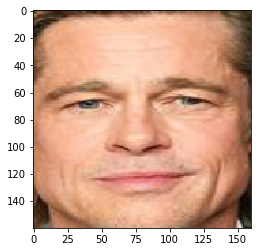

In [5]:
from matplotlib import pyplot as plt
plt.imshow(face_1, interpolation='nearest')
plt.show()

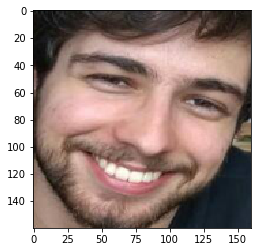

In [10]:
from matplotlib import pyplot as plt
plt.imshow(face_2, interpolation='nearest')
plt.show()

In [21]:
#np.round(model_output_2,3)
print([ "{:0.5f}".format(x) for x in model_output_2[0] ])

['0.02445', '0.06945', '0.10397', '-0.03266', '0.00765', '0.02254', '-0.04376', '-0.04091', '-0.00971', '-0.04160', '0.02689', '-0.03694', '0.03674', '0.03719', '0.00765', '-0.00565', '-0.05067', '0.01727', '-0.06345', '-0.00099', '0.00362', '-0.02516', '0.01938', '0.07532', '0.05133', '-0.01650', '-0.01711', '0.01062', '0.00634', '-0.05179', '0.01781', '0.00837', '-0.00145', '0.02527', '0.07811', '0.14274', '0.06681', '0.03207', '-0.03480', '-0.00078', '0.05804', '0.00822', '0.03461', '-0.06377', '-0.01850', '-0.02238', '-0.01306', '0.03595', '0.00229', '-0.01142', '0.01678', '-0.03515', '-0.02136', '0.05294', '0.08354', '0.01137', '-0.00524', '0.00194', '0.05151', '-0.02612', '0.06709', '-0.03541', '0.04646', '-0.00749', '0.06474', '-0.06318', '0.03325', '0.06432', '0.05168', '0.10486', '0.03987', '0.02295', '-0.05940', '-0.01810', '0.07675', '-0.09205', '-0.05658', '0.11702', '0.01740', '-0.00951', '0.05358', '0.03694', '-0.01138', '0.01330', '-0.02084', '0.03464', '0.07219', '0.017

In [6]:
print([ "{:0.5f}f".format(x) for x in model_output_1[0] ])

['0.02884f', '0.01993f', '-0.00736f', '-0.04338f', '0.00022f', '0.00318f', '0.01961f', '-0.00359f', '-0.05021f', '-0.00165f', '0.03113f', '-0.00927f', '-0.00625f', '-0.02603f', '0.05879f', '0.04900f', '0.06201f', '-0.04003f', '0.02943f', '0.01130f', '0.02063f', '0.01772f', '0.00632f', '0.08393f', '0.05378f', '-0.03953f', '-0.04109f', '0.02518f', '0.02911f', '0.07313f', '-0.04173f', '-0.04738f', '-0.03667f', '-0.01990f', '0.05441f', '-0.02558f', '0.04490f', '-0.03970f', '0.08077f', '-0.03379f', '0.02186f', '0.06270f', '0.03135f', '0.00298f', '-0.04477f', '-0.01237f', '-0.01102f', '-0.03009f', '0.00501f', '0.05737f', '-0.03013f', '-0.04029f', '-0.01090f', '-0.01587f', '0.07338f', '-0.02928f', '-0.01585f', '-0.01760f', '0.01433f', '0.10377f', '0.04626f', '0.03501f', '0.00088f', '-0.01569f', '0.03402f', '-0.01198f', '0.06832f', '0.00114f', '0.06623f', '0.00144f', '0.00458f', '-0.02227f', '0.01763f', '0.03448f', '-0.02363f', '0.04443f', '0.06997f', '0.03910f', '0.08645f', '0.06327f', '-0.00